In [116]:
f_leftandright = open('leftandright', 'rb')
left_lst = []
right_lst = []
pan_lst = []
tilt_lst = []

for i in range(5120):
  left = f_leftandright.read(4)
  right = f_leftandright.read(4)
  pan = f_leftandright.read(4)
  tilt = f_leftandright.read(4)
  left_lst.append(int.from_bytes(left, byteorder = 'little' ,signed = True))
  right_lst.append(int.from_bytes(right, byteorder = 'little' ,signed = True))
  pan_lst.append(int.from_bytes(pan, byteorder = 'little' ,signed = True))
  tilt_lst.append(int.from_bytes(tilt, byteorder = 'little' ,signed = True))

f_offset = open('offset', 'rb')
panoff_lst = []
tiltoff_lst = []
rotateoff_lst = []
tranoff_lst = []

for i in range(5120):
  panoff = f_offset.read(4)
  tiltoff = f_offset.read(4)
  rotateoff = f_offset.read(4)
  tranoff = f_offset.read(4)
  panoff_lst.append(int.from_bytes(panoff, byteorder = 'little' ,signed = True))
  tiltoff_lst.append(int.from_bytes(tiltoff, byteorder = 'little' ,signed = True))
  rotateoff_lst.append(int.from_bytes(rotateoff, byteorder = 'little' ,signed = True))
  tranoff_lst.append(int.from_bytes(tranoff, byteorder = 'little' ,signed = True))

rotatecom = []
translatecom = []
for i in range(5120):
  rotatecom.append((right_lst[i] - left_lst[i])/2)
  translatecom.append((right_lst[i] + left_lst[i])/2)

In [117]:
import numpy as np

import tensorflow as tf

In [118]:
size = 5120
datanum = 10
purpose_offset = tiltoff_lst
purpose_value = tilt_lst

In [119]:
input_lst = []
for i in range(size - datanum + 1):
  box = []
  for j in range(i, i+datanum, 1):
    box.append(purpose_offset[j])
  input_lst.append(box)

label_lst = []
for i in range(datanum - 1, size, 1):
  box = []
  box.append(purpose_value[i])
  label_lst.append(box)


In [120]:
panoff_numpy = np.array(input_lst)
pancom_numpy = np.array(label_lst)

In [121]:
print(panoff_numpy.shape, pancom_numpy.shape)

(5111, 10) (5111, 1)


In [122]:
mean_vals = np.mean(panoff_numpy, axis=0)
std_val = np.std(panoff_numpy)

mean_vals_com = np.mean(pancom_numpy, axis=0)
std_val_com = np.std(pancom_numpy)

In [123]:
panoff_numpy_centered = (panoff_numpy - mean_vals)/std_val
pancom_numpy_centered = (pancom_numpy - mean_vals_com)/std_val_com

# panoff_numpy_centered = (panoff_numpy - np.max(panoff_numpy))/(np.max(panoff_numpy) - np.min(panoff_numpy))
# pancom_numpy_centered = (pancom_numpy - np.max(pancom_numpy))/(np.max(pancom_numpy) - np.min(pancom_numpy))


In [124]:
train_x = np.ones((4000, datanum))
train_y = np.ones((4000, 1))
test_x = np.ones((1120 - datanum + 1, datanum))
test_y = np.ones((1120 - datanum + 1, 1))

for i in range(4000):
  train_x[i] = panoff_numpy_centered[i]
  train_y[i] = pancom_numpy_centered[i]

for i in range(4000, 5120 - datanum + 1, 1):
  test_x[i - 4000] = panoff_numpy_centered[i]
  test_y[i - 4000] = pancom_numpy_centered[i]

In [125]:
print(test_x)

[[-0.10674605 -0.10687173 -0.91001218 ... -0.53490329 -0.37457474
  -0.37477374]
 [-0.10674605 -0.90982366 -1.17766282 ... -0.37431291 -0.37457474
  -0.26771348]
 [-0.90969798 -1.1774743   0.10706026 ... -0.37431291 -0.26751449
  -0.1071231 ]
 ...
 [-0.26733644 -3.26514931  5.03183207 ...  0.10745825  0.05366628
   0.16052754]
 [-3.26502363  5.03202059  3.85416924 ...  0.05392812  0.16072654
  -0.26771348]
 [ 5.03214627  3.85435777  1.39178334 ...  0.16098838 -0.26751449
  -0.26771348]]


In [126]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=50,    
        input_dim = train_x.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(
    tf.keras.layers.Dense(
        units=50,    
        input_dim=100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))
model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(
    tf.keras.layers.Dense(
        units=train_y.shape[1],    
        input_dim=100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

In [127]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                550       
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 3,151
Trainable params: 3,151
Non-trainable params: 0
_________________________________________________________________


In [128]:
sgd_optimizer = tf.keras.optimizers.SGD(
    lr=0.000001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer,
              loss='mse')

In [ ]:
history = model.fit(train_x, train_y,
                    batch_size=1, epochs=50,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/50
3600/3600 [==============================] - 5s 1ms/step - loss: 1.1544 - val_loss: 1.5246
Epoch 2/50
 225/3600 [>.............................] - ETA: 3s - loss: 1.0505

1111/1111 [==============================] - 1s 854us/step - loss: 0.9548
[[-0.2688975 ]
 [-0.13907635]
 [-0.21460629]
 ...
 [-0.23089385]
 [-0.6460508 ]
 [-0.42226192]]


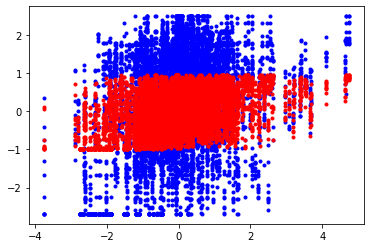

[0.22363019]


In [105]:


import matplotlib.pyplot as plt

loss_and_metrics = model.evaluate(test_x, test_y, batch_size=1)
xhat = test_x
yhat = model.predict(xhat)
print(yhat)


SSE_lst = [] 
SST_lst = []

means = test_y.sum()/test_y.shape[0]

for i in range(xhat.shape[0]):
  SSE_lst.append((test_y[i] - yhat[i])**2)
  SST_lst.append((test_y[i] - means)**2)

R_square = 1 - (sum(SSE_lst) / sum(SST_lst))


plt.plot(test_x, test_y, '.', color = 'b') 
plt.plot(xhat, yhat, '.', color = 'r') 

plt.show()

print(R_square)


In [113]:

print(test_y.shape)
print(yhat.shape)

(1111, 1)
(1111, 1)


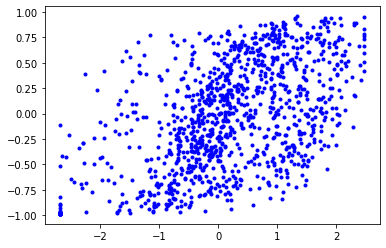

In [115]:
plt.plot(test_y, yhat, '.', color = 'b') 


plt.show()


4000/4000 [==============================] - 3s 818us/step - loss: 0.6134


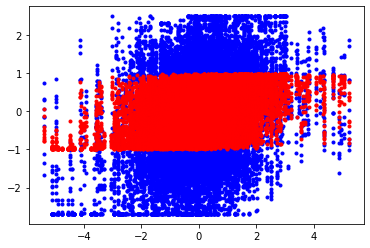

In [103]:
loss_and_metrics = model.evaluate(train_x, train_y, batch_size=1)
xhat = train_x
yhat = model.predict(xhat)

plt.plot(train_x, train_y, '.', color = 'b') 
plt.plot(xhat, yhat, '.', color = 'r') 
plt.show()